loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz

0
shift [0.], tilt [0.],  bias [0.], res [0.]
3.820974062155555e-11   2.6158690561181995e-12   2.3806779883010156   0.09003475845580057   0.1006355474201727   0.0407170582820953   1.0016949334936442   0.010746971207118535   -0.0031628596334033893   0.011544212834353897   2.154434690031884  
3.819170577053464e-11   4.6642260645146335e-12   2.3846679427115887   0.0903496885811423   0.09987220465476121   0.04078990570200503   -6.462127351764598e-06   0.10073300791165495   3.965075176479569e-06   0.0200000082880776   -6.462127351764598e-06   0.10073300791165495   3.965075176479569e-06   0.0200000082880776   0.0   0.0   0.0   0.0   2.154434690031884  

0.10000000000000002 TeV 0.1778279410038923 TeV
in parameter estimate best fit
in estimate_ts
in estimate_errn_errp
in estimate_ul
in estimate_scan

0.1778279410038923 TeV 0.316227766016838 TeV
in parameter esti

FileNotFoundError: [Errno 2] No such file or directory: '../Eff_area_PKSflare_crab_cutoff/data/fluxpoints/1P_fluxpoints_N_2.154434690031884_0.0_0.0_0.0_0.0.fits'

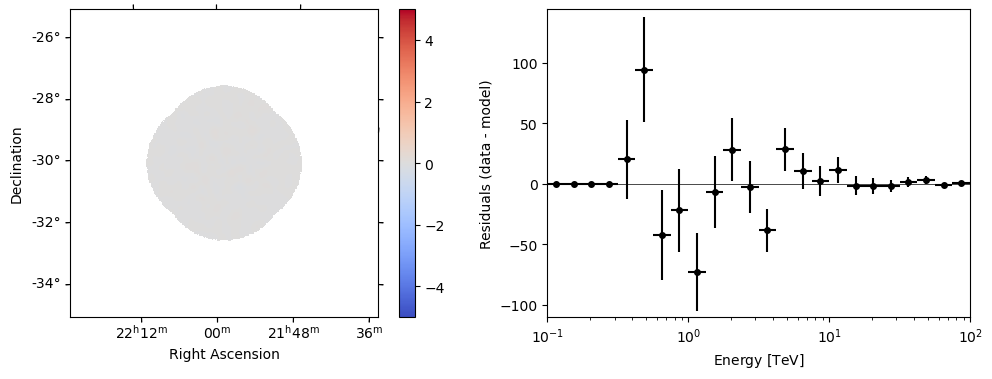

In [1]:
def save():
    with open(f"{path}/data/1_P_draw_info.txt", "a") as myfile:
        info = str(float(shift_rnd[0])) + '    '+ str(float(tilt_rnd[0])) + '    '
        info += str(float(bias_rnd[0])) + '    '+ str(float(res_rnd[0])) + '    '
        info +=  str(float(dataset.stat_sum())) + '\n'
        myfile.write(info)
    with open(f"{path}/data/1_P_draw_par.txt", "a") as myfile:
        myfile.write(stri + '\n')
    with open(f"{path}/data/1_P_draw_flux.txt", "a") as myfile:
        myfile.write( ff + '\n')
    with open(f"{path}/data/1_P_draw_flux2e.txt", "a") as myfile:
        myfile.write( ff2 + '\n')

    with open(f"{path}/data/1_N_P_draw_par.txt", "a") as myfile:
        myfile.write(stri_N + '\n')
    with open(f"{path}/data/1_N_P_draw_flux.txt", "a") as myfile:
        myfile.write( ffN + '\n')
    with open(f"{path}/data/1_N_P_draw_flux2e.txt", "a") as myfile:
        myfile.write( ffN2 + '\n')
        
def computing_contour(dataset, note):
        
    results = []
    for parname1, parname2 in parameter_names :
        print( parname1, parname2)
        result = fit_cor.stat_contour(dataset,
                             dataset.models.parameters[parname1],
                             dataset.models.parameters[parname2],
                            )

        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "success":
                contour_write[k] = result[k].tolist()
        import yaml
        with open(f"{path}/data/contours/{note}_{parname1}_{parname2}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)



import gammapy 
import pyximport
import numpy as np
import astropy.units as u
import sys
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import Models
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
from gammapy.modeling.models import IRFModels, EffAreaIRFModel, ERecoIRFModel
    
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
import Dataset_load 
from  Dataset_Setup import Setup, GaussianCovariance_matrix


c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

livetimes = c['livetimes']
livetime = c['livetime']
sys = c['sys']
norm = c['norm'] 
tilt = c['tilt'] 
bias =  c['bias'] 
resolution = c['resolution'] 
path = f"../{c['folder']}"
parameter_names = c['parameter_names']        

#for live in livetimes[8:]:
for live in [livetime]:

    dataset_asimov = Dataset_load.create_asimov(
        model=c['model'], source=c['source'], parameters=None,
        livetime = f"{live}-hr"
    )

    mask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1)>0
    ebins = dataset_asimov.counts.geom.axes[0].center[mask]


    N = 1
    save_flux = True
    save_fluxpoints = 0
    save_fluxpoints_N = 1
    dataset_N = True
    contour = 0


    for n in range(N):
        print()
        print('====' * 30)
        print(n)
        print('====' * 30)
        res_rnd = np.random.normal(0, resolution, 1)
        bias_rnd =  np.random.normal(0, bias, 1)
        shift_rnd = np.random.normal(0, norm, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        zero_sys = 1
        if zero_sys:
            shift_rnd, tilt_rnd = np.array([0.]), np.array([0.])
            bias_rnd, res_rnd = np.array([0.]), np.array([0.])
        
        print(f"shift {shift_rnd}, tilt {tilt_rnd},  bias {bias_rnd}, res {res_rnd}")
        setup = Setup(dataset_input=dataset_asimov, rnd = True)
        setup.set_up_irf_sys(bias_rnd, res_rnd, shift_rnd, tilt_rnd)

        dataset, dataset_N = setup.run()
        # irf model
        # happens in set_up_irf_sys
        # setup.set_irf_model(dataset_N)
        if sys == "Eff_area":
            dataset_N.models.parameters['resolution'].frozen = True
            dataset_N.models.parameters['bias'].frozen = True
            dataset_N.irf_model.parameters['tilt'].frozen = False
            dataset_N.irf_model.parameters['norm'].frozen = False
            
        if sys == "E_reco":
            dataset_N.models.parameters['resolution'].frozen = True
            dataset_N.models.parameters['bias'].frozen = False
            dataset_N.irf_model.parameters['tilt'].frozen = True
            dataset_N.irf_model.parameters['norm'].frozen = True
            
            
        if sys == "Combined":
            dataset_N.models.parameters['resolution'].frozen = True
            dataset_N.models.parameters['bias'].frozen = False
            dataset_N.irf_model.parameters['tilt'].frozen = False
            dataset_N.irf_model.parameters['norm'].frozen = False
            
        setup.set_irf_prior(dataset_N, bias, resolution, norm, tilt)
        fit_cor = Fit(store_trace=False)
        dataset.plot_residuals()
        result_cor = fit_cor.run([dataset])
        

        stri = ""
        parameters =  ['amplitude', 'index', 'lambda_', 'norm', 'tilt']
        if "crab_break" in c['model']:
            parameters =  ['amplitude', 'index1', 'index2', 'ebreak', 'beta', 'norm', 'tilt']
        if "crab_log" in c['model']:
            parameters =  ['amplitude', 'alpha', 'beta', 'norm', 'tilt']
            
        for p in parameters:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        stri += str(live) + "  "
        print(stri)


        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)

        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            len(ebins),
        )
        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff2 = str()
        for f in fluxe2:
            ff2 += str(f) + "  "

        energy_edges = dataset.geoms['geom'].axes[0].edges[::2]

        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset_N])

        stri_N = ""
        [parameters.append(p) for p in ['norm', 'tilt', 'bias', 'resolution']]
        for p in parameters:
            stri_N += str(dataset_N.models.parameters[p].value)  + '   ' +  str(dataset_N.models.parameters[p].error)  + '   '
        stri_N += str(live) + "  "
        print(stri_N)

        fluxes = []
        for e in ebins:
            flux =  dataset_N.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ffN = str()
        for f in fluxes:
            ffN += str(f) + "  "

        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            len(ebins),
        )

        fluxe2, _ = dataset_N.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ffN2 = str()
        for f in fluxe2:
            ffN2 += str(f) + "  "

        rnds = f"{shift_rnd[0]:.6}_{tilt_rnd[0]:.6}_{bias_rnd[0]:.6}_{res_rnd[0]:.6}"
        if save_fluxpoints:
            dataset.models.parameters['amplitude'].scan_n_sigma  = 5
            dataset_N.models.parameters['amplitude'].scan_n_sigma  = 5

            esti  = FluxPointsEstimator(energy_edges= energy_edges, 
                                        selection_optional =  "all"
                                       )
            fluxpoints = esti.run([dataset])
            # freeze all but IRF for fp and reopt = True
            dataset_N.models[0].parameters.freeze_all()
            dataset_N.models[0].parameters['amplitude'].frozen = False
            dataset_N.background_model.parameters.freeze_all()
            esti  = FluxPointsEstimator(energy_edges= energy_edges, selection_optional = None, #"all",
                                       reoptimize=True)
            fluxpoints_N = esti.run([dataset_N])
            fluxpoints_N.write(f'{path}/data/fluxpoints/1P_fluxpoints_N_{live}_{rnds}.fits',
                              overwrite = True)
            dataset_N.models.write(f'{path}/data/fluxpoints/1P_model_N_{live}_{rnds}.yaml',
                                  overwrite = True)
            fluxpoints.write(f'{path}/data/fluxpoints/1P_fluxpoints_{live}_{rnds}.fits',
                            overwrite = True)
            dataset.models.write(f'{path}/data/fluxpoints/1P_model_{live}_{rnds}.yaml',
                                overwrite = True)
        if contour:
            computing_contour(dataset, rnds)
            computing_contour(dataset_N, "N"+rnds)

        if zero_sys == False: # else only the fluxpoints and models are saved but not the info
            save()
        plotting = 0
        if plotting:
            import matplotlib.pyplot as plt

            ep = 2
            ax = dataset.models[0].spectral_model.plot((0.1,100)*u.TeV, color = 'tab:blue',
                                                      label = "without nui",
                                                      energy_power = ep)


            dataset_asimov.models[0].spectral_model.plot((0.1,100)*u.TeV,ax = ax, color = 'black',
                                                        energy_power = ep)

            dataset_N.models[0].spectral_model.plot((0.1,100)*u.TeV,ax = ax, color = 'tab:orange',
                                                   label = "with nui",
                                                   energy_power = ep)
            dataset_N.models[0].spectral_model.plot_error((0.1,100)*u.TeV,ax = ax, facecolor = 'tab:orange',
                                                         energy_power = ep)
            dataset.models[0].spectral_model.plot_error((0.1,100)*u.TeV,ax = ax, facecolor = 'tab:blue',
                                                       energy_power = ep)
            try:
                fluxpoints_N.plot(ax =ax,energy_power = ep )
                fluxpoints.plot(ax =ax, energy_power = ep)
            except:
                kk = 0
            ax.legend(title = f"live: {live} hr norm:{shift_rnd[0]:.3} tilt:{tilt_rnd[0]:.3}")
            fig = plt.gcf()
            fig.savefig(f"{path}/data/plots/{live}_{rnds}.png")
            plt.close()